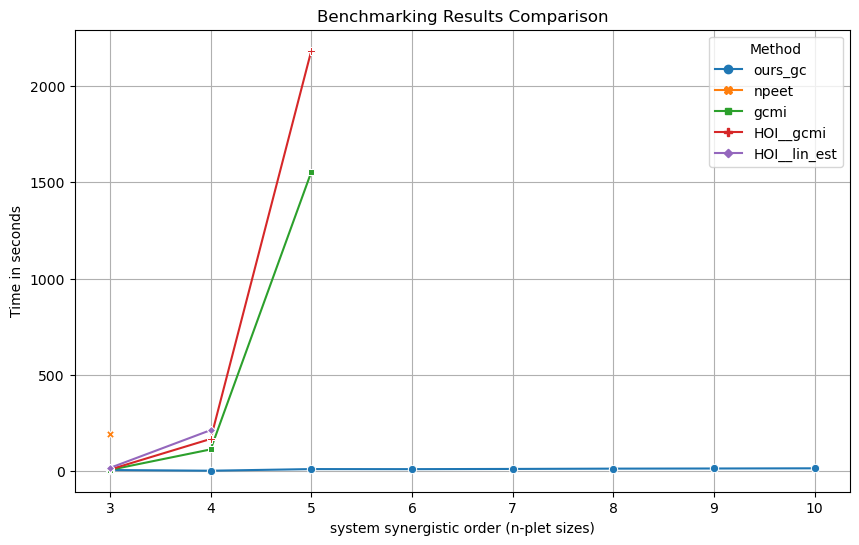

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the file paths
file_paths = [
    "library-thoi_estimator-gc.tsv",
    "library-hoi_estimator-gcmi.tsv",
    "library-hoi_estimator-linest.tsv",
    "library-gcmi_estimator-gcmi.tsv",
    "library-npeet_estimator-npeet.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path in file_paths:
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    dataframes.append(df)

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['library-estimator'] = combined_df['library'] + '--' + combined_df['estimator']

# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="library-estimator", style='library-estimator',
    markers=True, dashes=False
)

plt.title('Benchmarking Results Comparison')
plt.xlabel('system synergistic order (n-plet sizes)')
plt.ylabel('Time in seconds')
plt.legend(title='Method')
plt.grid(True)
plt.show()